# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [2]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt

Now you can load the data:

In [3]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

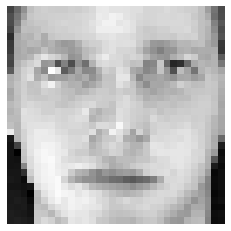

In [5]:
# Display a single example.
show_single_face(data[0, :])

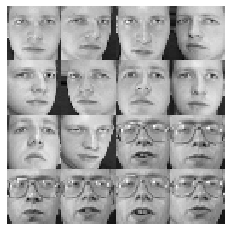

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [4]:
# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares (13 Marks in Total)
### 3.1 Implementation (5 Marks, Easy)
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [5]:
def l2_rls_train(data, labels, reg_param):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    Xa = np.ones((1,X.shape[0]))
    X_tilde = np.append(Xa.T, X, axis=1)
    
    # Compute the coefficient vector.
    if (reg_param == 0):
        w = np.linalg.pinv(X_tilde) @ y
        
    elif (reg_param > 0):
        #calculation using formula
        w = np.linalg.inv((X_tilde.T @ X_tilde) + (reg_param * np.eye(len(X_tilde[1,:])))) @ X_tilde.T @ y
    else:
        print("Please use correct regularisation parameter")
        return -1
    # Return model parameters.
    return w

Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [6]:
def l2_rls_predict(w, data):
    """
    A summary of your function goes here.

    data: type and description of "data"
    w: type and description of "w"

    Returns: type and description of the returned variable(s).
    """
    
    # Expand X with a column of ones.
    Xa = np.ones((1,data.shape[0]))
    X_tilde = np.append(Xa.T, data, axis=1)
    
   # Compute the prediction.
    predicted_y = X_tilde @ w
        
    return predicted_y

#### Report

Explain briefly the knowledge supported your implementation and your design step by step.

### 3.2 Experiments (2 experiments to be implemented) 

Use your implemented functions to perform the following experiments. Experiment 1 is compulsory. Between Experiment 2 and Experiment 3, choose one as you like.

#### Experiment 1: Binary Classification (4 Marks, Normal)

Start with a binary classification to classify face images for subjects “1” and “30”.

Train three classifiers:
<br>Classifier 1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” for training a linear model, and use the threshold $T= 0$ to obtain the class prediction.
<br>Classifier 2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” for training a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
<br>Classifier 3. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” for training a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [56]:
# Your code goes here
trials = 50
accuracy = []
tr_accuracy1 = []
threshold = 0

for i in range(trials):
    #Selects data
    tr_ind, te_ind = partition_data(labels, num_per_class=3)

    tr_ind_n = np.empty([1,0])
    te_ind_n = np.empty([1,0])

    for i in range(len(tr_ind)):
        if(labels[tr_ind[i]] == 1 or labels[tr_ind[i]] == 30):
            tr_ind_n = np.append(int(tr_ind[i]), tr_ind_n)

    for i in range(len(te_ind)):
        if(labels[te_ind[i]] == 1 or labels[te_ind[i]] == 30):
            te_ind_n = np.append(int(te_ind[i]), te_ind_n)        

    tr_ind_n = tr_ind_n.astype(int)
    te_ind_n = te_ind_n.astype(int)
    
    #training data
    tr_data = data[tr_ind_n, :]
    #real labels
    r_labels = labels[tr_ind_n]
    #training labels
    tr_labels = np.empty([1,0])

    for i in range(len(tr_ind_n)):
        if(labels[tr_ind_n[i]] == 1):
            tr_labels = np.append(-1, tr_labels)
        else:
            tr_labels = np.append(1, tr_labels)
    tr_labels = tr_labels.astype(int)        
    
    #weight
    weight = l2_rls_train(tr_data, tr_labels, 0)
    #training prediction
    tr_prediction = l2_rls_predict(weight , tr_data)
    #testing data
    te_data = data[te_ind_n, :]
    #testing labels
    te_labels = labels[te_ind_n]
    #testing prediction
    te_prediction = l2_rls_predict(weight, te_data)
    
    #thresholding
    predicted_labels = np.empty([1,0])
    #testing thresholding
    for i in range(len(te_prediction)):
        if (te_prediction[i] >= threshold):
            predicted_labels = np.append(int(30),predicted_labels)
        else:
            predicted_labels = np.append(int(1),predicted_labels)
            
            
    predicted_labels = predicted_labels.astype(int)
    #training thresholding
    tr_predicted_labels = np.empty([1,0])
    for i in range(len(tr_prediction)):
        if (tr_prediction[i] >= threshold):
            tr_predicted_labels = np.append(int(30),tr_predicted_labels)
        else:
            tr_predicted_labels = np.append(int(1),tr_predicted_labels)
            
            
    tr_predicted_labels = tr_predicted_labels.astype(int)
    
    #testing accuracy
    accuracy.append(np.count_nonzero(predicted_labels == te_labels)/ len(te_labels))
    #training accuracy
    tr_accuracy1.append(np.count_nonzero(tr_predicted_labels == r_labels)/ len(r_labels))
#average testing accuracy
mean1 = np.mean(accuracy)
#standard deviation
standard_deviation1 = np.std(accuracy)




In [162]:
# Your code goes here

Repeat the same experiment for classifier 2.

In [57]:
# Your code goes here
trials = 50
accuracy = []
tr_accuracy2 = []
threshold = 0.5

for i in range(trials):
    #Selects data
    tr_ind, te_ind = partition_data(labels, num_per_class=3)

    tr_ind_n = np.empty([1,0])
    te_ind_n = np.empty([1,0])

    for i in range(len(tr_ind)):
        if(labels[tr_ind[i]] == 1 or labels[tr_ind[i]] == 30):
            tr_ind_n = np.append(int(tr_ind[i]), tr_ind_n)

    for i in range(len(te_ind)):
        if(labels[te_ind[i]] == 1 or labels[te_ind[i]] == 30):
            te_ind_n = np.append(int(te_ind[i]), te_ind_n)        

    tr_ind_n = tr_ind_n.astype(int)
    te_ind_n = te_ind_n.astype(int)
    
    #training data
    tr_data = data[tr_ind_n, :]
    #real labels
    r_labels = labels[tr_ind_n]
    #training labels
    tr_labels = np.empty([1,0])

    for i in range(len(tr_ind_n)):
        if(labels[tr_ind_n[i]] == 1):
            tr_labels = np.append(0, tr_labels)
        else:
            tr_labels = np.append(1, tr_labels)
    tr_labels = tr_labels.astype(int)        
    
    #weight
    weight = l2_rls_train(tr_data, tr_labels, 0)
    #training prediction
    tr_prediction = l2_rls_predict(weight , tr_data)
    #testing data
    te_data = data[te_ind_n, :]
    #testing labels
    te_labels = labels[te_ind_n]
    #testing prediction
    te_prediction = l2_rls_predict(weight, te_data)
    
    #thresholding
    predicted_labels = np.empty([1,0])
    #testing thresholding
    for i in range(len(te_prediction)):
        if (te_prediction[i] >= threshold):
            predicted_labels = np.append(int(30),predicted_labels)
        else:
            predicted_labels = np.append(int(1),predicted_labels)
            
            
    predicted_labels = predicted_labels.astype(int)
    
    #training thresholding
    tr_predicted_labels = np.empty([1,0])
    for i in range(len(tr_prediction)):
        if (tr_prediction[i] >= threshold):
            tr_predicted_labels = np.append(int(30),tr_predicted_labels)
        else:
            tr_predicted_labels = np.append(int(1),tr_predicted_labels)
            
            
    tr_predicted_labels = tr_predicted_labels.astype(int)
    
    #testing accuracy
    accuracy.append(np.count_nonzero(predicted_labels == te_labels)/ len(te_labels))
    #training accuracy
    tr_accuracy2.append(np.count_nonzero(tr_predicted_labels == r_labels)/ len(r_labels))
#average testing accuracy
mean2 = np.mean(accuracy)
standard_deviation2 = np.std(accuracy)




Repeat the same experiment for classifier 3.

In [58]:
# Your code goes here
trials = 50
accuracy = []
tr_accuracy3 = []
threshold = 15.5

for i in range(trials):
    #Selects data
    tr_ind, te_ind = partition_data(labels, num_per_class=3)

    tr_ind_n = np.empty([1,0])
    te_ind_n = np.empty([1,0])

    for i in range(len(tr_ind)):
        if(labels[tr_ind[i]] == 1 or labels[tr_ind[i]] == 30):
            tr_ind_n = np.append(int(tr_ind[i]), tr_ind_n)

    for i in range(len(te_ind)):
        if(labels[te_ind[i]] == 1 or labels[te_ind[i]] == 30):
            te_ind_n = np.append(int(te_ind[i]), te_ind_n)        

    tr_ind_n = tr_ind_n.astype(int)
    te_ind_n = te_ind_n.astype(int)
    
    #training data
    tr_data = data[tr_ind_n, :]
    #real labels
    r_labels = labels[tr_ind_n]
    #training labels
    tr_labels = np.empty([1,0])

    for i in range(len(tr_ind_n)):
        if(labels[tr_ind_n[i]] == 1):
            tr_labels = np.append(1, tr_labels)
        else:
            tr_labels = np.append(30, tr_labels)
    tr_labels = tr_labels.astype(int)        
    
    #weight
    weight = l2_rls_train(tr_data, tr_labels, 0)
    #training prediction
    tr_prediction = l2_rls_predict(weight , tr_data)
    #testing data
    te_data = data[te_ind_n, :]
    #testing labels
    te_labels = labels[te_ind_n]
    #testing prediction
    te_prediction = l2_rls_predict(weight, te_data)
    
    #thresholding
    predicted_labels = np.empty([1,0])
    
    for i in range(len(te_prediction)):
        if (te_prediction[i] >= threshold):
            predicted_labels = np.append(int(30),predicted_labels)
        else:
            predicted_labels = np.append(int(1),predicted_labels)
            
            
    predicted_labels = predicted_labels.astype(int)
    
    tr_predicted_labels = np.empty([1,0])
    for i in range(len(tr_prediction)):
        if (tr_prediction[i] >= threshold):
            tr_predicted_labels = np.append(int(30),tr_predicted_labels)
        else:
            tr_predicted_labels = np.append(int(1),tr_predicted_labels)
            
            
    tr_predicted_labels = tr_predicted_labels.astype(int)
    
    
    accuracy.append(np.count_nonzero(predicted_labels == te_labels)/ len(te_labels))
    tr_accuracy3.append(np.count_nonzero(tr_predicted_labels == r_labels)/ len(r_labels))
mean3 = np.mean(accuracy)
standard_deviation3 = np.std(accuracy)




Print out the mean and the std values of the test errors of the three classifiers.

In [59]:
print("Classifier 1 mean: ", mean1)
print("Classifier 1 standard deviation: ", standard_deviation1)
print("Classifier 2 mean: ",mean2)
print("Classifier 2 standard deviation: ",standard_deviation2)
print("Classifier 3 mean: ",mean3)
print("Classifier 3 standard deviation: ",standard_deviation3)

Classifier 1 mean:  0.93
Classifier 1 standard deviation:  0.08267220740703023
Classifier 2 mean:  0.9371428571428573
Classifier 2 standard deviation:  0.08407965125464094
Classifier 3 mean:  0.9357142857142857
Classifier 3 standard deviation:  0.07457361792078966


#### Report

Explain the classification steps. Does changing the class labels impact the model performance? Explain why it does/doesn't impact.  What training accuracies do you obtain with your linear classifier? Analyse the reason.

#### Experiment 2: Multi-class Classification (4 Marks, Normal)

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [10]:
# Your code goes here
trials = 20
te_accuracy = []
tr_accuracy = []
testing_error_rate = []

for k in range(trials): 
    #Selects data
    tr_ind, te_ind = partition_data(labels, num_per_class=5)        

    #training data
    tr_data = data[tr_ind, :]
    #real labels
    tr_labels = labels[tr_ind]

    tr_en_labels = np.empty([0,40])

    #one-hot encoding
    for i in range(len(tr_labels)):
        en_zero = np.zeros((1,40))
        en_zero[0,(tr_labels[i]-1)] = 1
        tr_en_labels = np.vstack([en_zero,tr_en_labels])

    tr_labels = tr_en_labels


    #weight
    weight = l2_rls_train(tr_data, tr_labels, k)
    #training prediction
    tr_prediction = l2_rls_predict(weight , tr_data)

    #finding maximum or prediction
    no_rows = len(tr_prediction)
    no_column = len(tr_prediction[0])
    #final predictions
    tr_pred_max = np.empty([0,1])

    for i in range(no_rows):
        max1=0
        col_pos = 0
        for j in range(no_column):
            if tr_prediction[i][j] > max1:
                max1 = tr_prediction[i][j]
                col_pos = j+1
        tr_pred_max = np.append(col_pos, tr_pred_max)
        
    tr_labels = labels[tr_ind]
    tr_accuracy.append(np.count_nonzero(tr_pred_max == tr_labels)/ len(tr_labels))





#Selects data
tr_ind, te_ind = partition_data(labels, num_per_class=5)        

#training data
tr_data = data[tr_ind, :]
#real labels
tr_labels = labels[tr_ind]

tr_en_labels = np.empty([0,40])

#one-hot encoding
for i in range(len(tr_labels)):
    en_zero = np.zeros((1,40))
    en_zero[0,(tr_labels[i]-1)] = 1
    tr_en_labels = np.vstack([en_zero,tr_en_labels])

tr_labels = tr_en_labels


#weight
weight = l2_rls_train(tr_data, tr_labels, 2)
#testing data
te_data = data[te_ind, :]
#testing labels
te_labels = labels[te_ind]

#testing prediction
te_prediction = l2_rls_predict(weight, te_data)

#finding maximum or prediction
no_rows_te = len(te_prediction)
no_column_te = len(te_prediction[0])
#final predictions
te_pred_max = np.empty([0,1])

#finding maximum value
for i in range(no_rows_te):
    max1=0
    col_pos = 0
    for j in range(no_column_te):
        if te_prediction[i][j] > max1:
            max1 = te_prediction[i][j]
            col_pos = j+1
    te_pred_max = np.append(col_pos, te_pred_max)
#testing accuracy
te_accuracy.append(np.count_nonzero(te_pred_max == te_labels)/ len(te_labels))
testing_error_rate.append(np.count_nonzero(te_pred_max != te_labels)/ len(te_labels))


print("training accuracy:",tr_accuracy)
print("testing accuracy:",te_accuracy)
print("testing error rate:",testing_error_rate)

    
    



training accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
testing accuracy: [0.925]
testing error rate: [0.075]


 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

In [14]:
# Your code goes here

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

In [15]:
# Your code goes here

#### Report

Explain the classification steps. How do you pick the most difficult and easiest subjects to classify,  analyse the results.

#### Experiment 3: Face Completion (4 Marks, Normal)

The task is to predic the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [16]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

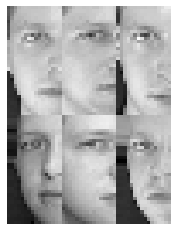

In [17]:
show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your functions implemented earlier. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [18]:
# Your code goes here

Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

In [19]:
# Your code goes here

#### Report

Analyse results of face completion model, how well your model performed, how it can be improved? 


## 4. Gradient descent for training linear least squares model (5 Marks in Total, Normal)

Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [12]:
def lls_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    cost_all = []
    w_all = np.empty([0,1025])
    
    # Expand X with a column of ones.
    Xa = np.ones((1,X.shape[0]))
    X_tilde = np.append(Xa.T, X, axis=1)
    
    # Weight initialization
    w = np.zeros(len(X_tilde.T))
    
    

    # GD update of weights
    for i in range(N):
        
        # cost and gradient descent of the linear least squares model
        gd = X_tilde.T @ X_tilde @ w - X_tilde.T @ y
        
        cost = 0.5 * np.sum(np.square(X_tilde @ w - y))
        
        # Weight update
        w = w - learning_rate * gd
        
        # save w and cost of each iteration in w_all and cost_all 
        w_all = np.vstack([w,w_all])
        
        cost_all.append(cost)
    # Return model parameters.
    return cost_all, w_all


Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it compiles. 

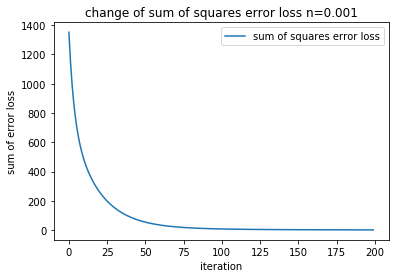

In [19]:
#splitting the data
tr_ind, te_ind = partition_data(labels, num_per_class=3)
threshold = 0
#indices
tr_ind_n = np.empty([1,0])
te_ind_n = np.empty([1,0])
#splits into 1 and 30
for i in range(len(tr_ind)):
    if(labels[tr_ind[i]] == 1 or labels[tr_ind[i]] == 30):
        tr_ind_n = np.append(int(tr_ind[i]), tr_ind_n)

for i in range(len(te_ind)):
    if(labels[te_ind[i]] == 1 or labels[te_ind[i]] == 30):
        te_ind_n = np.append(int(te_ind[i]), te_ind_n)        

tr_ind_n = tr_ind_n.astype(int)
te_ind_n = te_ind_n.astype(int)

tr_data = data[tr_ind_n, :]
tr_label = labels[tr_ind_n]
#cost and weights
cost_all, w_all = lls_gd_train(tr_data, tr_label, 0.001, 200)

#draws graph for error loss
xsq = np.arange(0,200)
ysq = cost_all

plt.title("change of sum of squares error loss n=0.001")
plt.plot(xsq, ysq, label = "sum of squares error loss")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("sum of error loss")

plt.show()






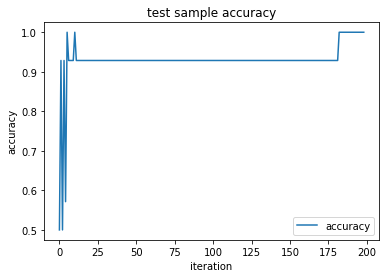

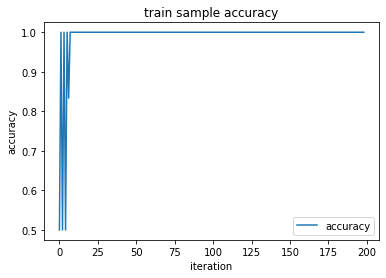

In [15]:
#Selects data
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_accuracy = []
te_accuracy = []
threshold = 0
tr_ind_n = np.empty([1,0])
te_ind_n = np.empty([1,0])

for i in range(len(tr_ind)):
    if(labels[tr_ind[i]] == 1 or labels[tr_ind[i]] == 30):
        tr_ind_n = np.append(int(tr_ind[i]), tr_ind_n)

for i in range(len(te_ind)):
    if(labels[te_ind[i]] == 1 or labels[te_ind[i]] == 30):
        te_ind_n = np.append(int(te_ind[i]), te_ind_n)        

tr_ind_n = tr_ind_n.astype(int)
te_ind_n = te_ind_n.astype(int)

#training data
tr_data = data[tr_ind_n, :]
#real labels
r_labels = labels[tr_ind_n]
#training labels
tr_labels = np.empty([1,0])

for i in range(len(tr_ind_n)):
    if(labels[tr_ind_n[i]] == 1):
        tr_labels = np.append(-1, tr_labels)
    else:
        tr_labels = np.append(1, tr_labels)
tr_labels = tr_labels.astype(int)

cost_all, w_all = lls_gd_train(tr_data, tr_labels, 0.001, 200)

for k in range(199,0,-1):
    #weight
    weight = w_all[k].T
    #training prediction
    tr_prediction = l2_rls_predict(weight , tr_data)
    #testing data
    te_data = data[te_ind_n, :]
    #testing labels
    te_labels = labels[te_ind_n]
    #testing prediction
    te_prediction = l2_rls_predict(weight, te_data)

    #thresholding
    predicted_labels = np.empty([1,0])

    for i in range(len(te_prediction)):
        if (te_prediction[i] >= threshold):
            predicted_labels = np.append(int(30),predicted_labels)
        else:
            predicted_labels = np.append(int(1),predicted_labels)


    predicted_labels = predicted_labels.astype(int)
    
    tr_predicted_labels = np.empty([1,0])
    for i in range(len(tr_prediction)):
        if (tr_prediction[i] >= threshold):
            tr_predicted_labels = np.append(int(30),tr_predicted_labels)
        else:
            tr_predicted_labels = np.append(int(1),tr_predicted_labels)


    tr_predicted_labels = tr_predicted_labels.astype(int)


    te_accuracy.append(np.count_nonzero(predicted_labels == te_labels)/ len(te_labels))
    tr_accuracy.append(np.count_nonzero(tr_predicted_labels == r_labels)/ len(r_labels))


# draws graph for test sample accuracy
xsq = np.arange(0,199)
ysq = te_accuracy
plt.title("test sample accuracy")
plt.plot(xsq, ysq, label = "accuracy")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("accuracy")

plt.show()

xsq = np.arange(0,199)
ysq = tr_accuracy

# draws graph for training sample accuracy
plt.title("training sample accuracy")
plt.plot(xsq, ysq, label = "accuracy")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("accuracy")

plt.show()

Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it compiles. 

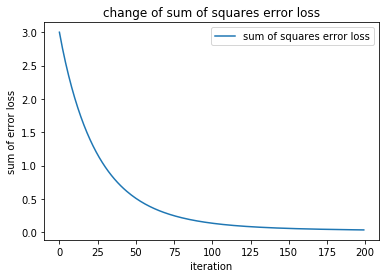

In [16]:
#to filter warnings
import warnings
warnings.filterwarnings('error')
#selects data
tr_ind, te_ind = partition_data(labels, num_per_class=3)
threshold = 0

tr_ind_n = np.empty([1,0])
te_ind_n = np.empty([1,0])
#splits into either 1 or 30
for i in range(len(tr_ind)):
    if(labels[tr_ind[i]] == 1 or labels[tr_ind[i]] == 30):
        tr_ind_n = np.append(int(tr_ind[i]), tr_ind_n)

for i in range(len(te_ind)):
    if(labels[te_ind[i]] == 1 or labels[te_ind[i]] == 30):
        te_ind_n = np.append(int(te_ind[i]), te_ind_n)        

tr_ind_n = tr_ind_n.astype(int)
te_ind_n = te_ind_n.astype(int)

tr_data = data[tr_ind_n, :]
tr_label = labels[tr_ind_n]
# gets cost and weights
try:
    cost_all, w_all = lls_gd_train(tr_data, tr_label, 0.01, 200)
except:
    print("")
xsq = np.arange(0,200)
ysq = cost_all

plt.title("change of sum of squares error loss n=0.01")
plt.plot(xsq, ysq, label = "sum of squares error loss")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("sum of error loss")

plt.show()


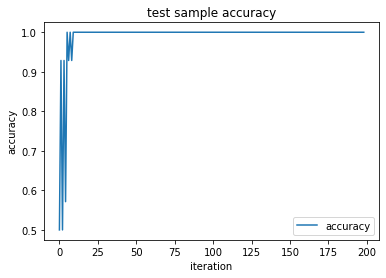

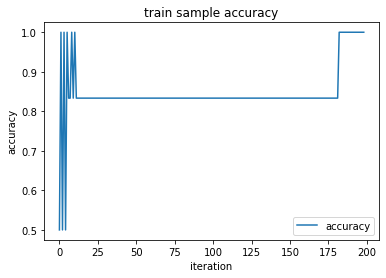

In [17]:
#Selects data
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_accuracy = []
te_accuracy = []
threshold = 0
tr_ind_n = np.empty([1,0])
te_ind_n = np.empty([1,0])

for i in range(len(tr_ind)):
    if(labels[tr_ind[i]] == 1 or labels[tr_ind[i]] == 30):
        tr_ind_n = np.append(int(tr_ind[i]), tr_ind_n)

for i in range(len(te_ind)):
    if(labels[te_ind[i]] == 1 or labels[te_ind[i]] == 30):
        te_ind_n = np.append(int(te_ind[i]), te_ind_n)        

tr_ind_n = tr_ind_n.astype(int)
te_ind_n = te_ind_n.astype(int)

#training data
tr_data = data[tr_ind_n, :]
#real labels
r_labels = labels[tr_ind_n]
#training labels
tr_labels = np.empty([1,0])

for i in range(len(tr_ind_n)):
    if(labels[tr_ind_n[i]] == 1):
        tr_labels = np.append(-1, tr_labels)
    else:
        tr_labels = np.append(1, tr_labels)
tr_labels = tr_labels.astype(int)
try:
    cost_all, w_all = lls_gd_train(tr_data, tr_labels, 0.01, 200)
except:
    print("")

for k in range(199,0,-1):
    #weight
    weight = w_all[k].T
    #training prediction
    tr_prediction = l2_rls_predict(weight , tr_data)
    #testing data
    te_data = data[te_ind_n, :]
    #testing labels
    te_labels = labels[te_ind_n]
    #testing prediction
    te_prediction = l2_rls_predict(weight, te_data)

    #thresholding
    predicted_labels = np.empty([1,0])

    for i in range(len(te_prediction)):
        if (te_prediction[i] >= threshold):
            predicted_labels = np.append(int(30),predicted_labels)
        else:
            predicted_labels = np.append(int(1),predicted_labels)


    predicted_labels = predicted_labels.astype(int)
    tr_predicted_labels = np.empty([1,0])
    for i in range(len(tr_prediction)):
        if (tr_prediction[i] >= threshold):
            tr_predicted_labels = np.append(int(30),tr_predicted_labels)
        else:
            tr_predicted_labels = np.append(int(1),tr_predicted_labels)


    tr_predicted_labels = tr_predicted_labels.astype(int)


    te_accuracy.append(np.count_nonzero(predicted_labels == te_labels)/ len(te_labels))
    tr_accuracy.append(np.count_nonzero(tr_predicted_labels == r_labels)/ len(r_labels))


# plots test graph
xsq = np.arange(0,199)
ysq = te_accuracy
plt.title("test sample accuracy")
plt.plot(xsq, ysq, label = "accuracy")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("accuracy")

plt.show()

#plots training graph
xsq = np.arange(0,199)
ysq = tr_accuracy

plt.title("training sample accuracy")
plt.plot(xsq, ysq, label = "accuracy")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("accuracy")

plt.show()

#### Report

How did you choose the learning rate and iteration number, explain your results.

## 5. Compare with stochastic gradient descent training (7 Marks In Total)
### 5.1 SGD Implementation (2 Marks, Normal)
Replace the gradient descent approach that you did in 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt the similar implementation template as used in your `lls_gd_train` function.

In [21]:
def lls_sgd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    cost_all = []
    w_all = np.empty([0,1025])
    
    # Expand X with a column of ones.
    Xa = np.ones((1,X.shape[0]))
    X_tilde = np.append(Xa.T, X, axis=1)
    
    # Weight initialization
    w = np.zeros(len(X_tilde.T))
    
    

    # GD update of weights
    for i in range(N):
        
        # cost and gradient descent of the linear least squares model
        gd = X_tilde.T @ X_tilde @ w - X_tilde.T @ y
        
        cost = 0.5 * np.square(X_tilde @ w - y)
        cost = cost[1]
        
        # Weight update
        w = w - learning_rate * gd
        
        # save w and cost of each iteration in w_all and cost_all 
        w_all = np.vstack([w,w_all])
        
        cost_all.append(cost)
    # Return model parameters.
    return cost_all, w_all

lls_gd_train(tr_data, tr_label, 0.001, 10)

([1351.5,
  1061.6136808413817,
  886.5032144645419,
  776.7851851639871,
  704.5445377376233,
  653.985475992775,
  616.1552182105619,
  585.9661541464561,
  560.515055493509,
  538.1342645344781],
 array([[0.12709521, 0.04313983, 0.10434878, ..., 0.03833238, 0.0743004 ,
         0.08238435],
        [0.12598426, 0.04285842, 0.09931093, ..., 0.03840824, 0.07051108,
         0.07782687],
        [0.1097981 , 0.037684  , 0.08820078, ..., 0.03252392, 0.06145919,
         0.06803129],
        ...,
        [0.09455779, 0.03189549, 0.05560685, ..., 0.03225505, 0.04095407,
         0.04340441],
        [0.03853523, 0.0134969 , 0.02770701, ..., 0.01134468, 0.01846568,
         0.02018031],
        [0.093     , 0.03046275, 0.04286667, ..., 0.03540784, 0.03526275,
         0.03593725]]))

### 5.2 Experiment Design (5 Marks, Hard)
Design and implement an appropriate experiment to demonstrate the perforamnce and behaviour difference between gradient descent and stochastic gradient descent. 


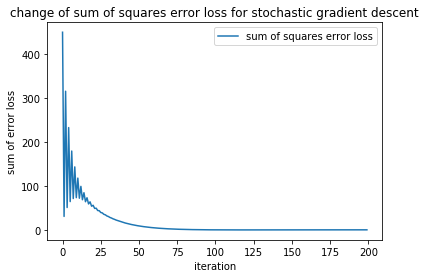

In [30]:
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_accuracy = []
te_accuracy = []
threshold = 0

tr_ind_n = np.empty([1,0])
te_ind_n = np.empty([1,0])

for i in range(len(tr_ind)):
    if(labels[tr_ind[i]] == 1 or labels[tr_ind[i]] == 30):
        tr_ind_n = np.append(int(tr_ind[i]), tr_ind_n)

for i in range(len(te_ind)):
    if(labels[te_ind[i]] == 1 or labels[te_ind[i]] == 30):
        te_ind_n = np.append(int(te_ind[i]), te_ind_n)        

tr_ind_n = tr_ind_n.astype(int)
te_ind_n = te_ind_n.astype(int)

tr_data = data[tr_ind_n, :]
tr_label = labels[tr_ind_n]

cost_all, w_all = lls_sgd_train(tr_data, tr_label, 0.001, 200)

xsq = np.arange(0,200)
ysq = cost_all
plt.title("change of sum of squares error loss for stochastic gradient descent")
plt.plot(xsq, ysq, label = "sum of squares error loss")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("sum of error loss")

plt.show()

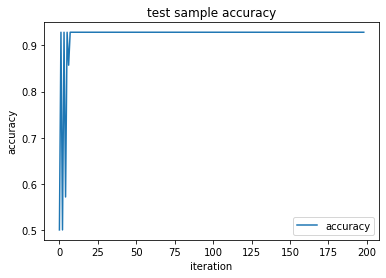

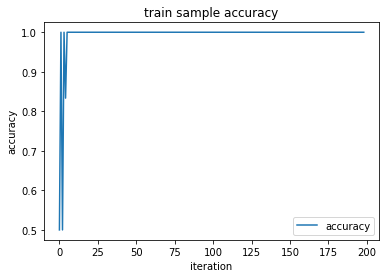

In [28]:
#Selects data
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_accuracy = []
te_accuracy = []
threshold = 0
tr_ind_n = np.empty([1,0])
te_ind_n = np.empty([1,0])

for i in range(len(tr_ind)):
    if(labels[tr_ind[i]] == 1 or labels[tr_ind[i]] == 30):
        tr_ind_n = np.append(int(tr_ind[i]), tr_ind_n)

for i in range(len(te_ind)):
    if(labels[te_ind[i]] == 1 or labels[te_ind[i]] == 30):
        te_ind_n = np.append(int(te_ind[i]), te_ind_n)        

tr_ind_n = tr_ind_n.astype(int)
te_ind_n = te_ind_n.astype(int)

#training data
tr_data = data[tr_ind_n, :]
#real labels
r_labels = labels[tr_ind_n]
#training labels
tr_labels = np.empty([1,0])

for i in range(len(tr_ind_n)):
    if(labels[tr_ind_n[i]] == 1):
        tr_labels = np.append(-1, tr_labels)
    else:
        tr_labels = np.append(1, tr_labels)
tr_labels = tr_labels.astype(int)
try:
    cost_all, w_all = lls_sgd_train(tr_data, tr_labels, 0.001, 200)
except:
    print("")

for k in range(199,0,-1):
    #weight
    weight = w_all[k].T
    #training prediction
    tr_prediction = l2_rls_predict(weight , tr_data)
    #testing data
    te_data = data[te_ind_n, :]
    #testing labels
    te_labels = labels[te_ind_n]
    #testing prediction
    te_prediction = l2_rls_predict(weight, te_data)

    #thresholding
    predicted_labels = np.empty([1,0])

    for i in range(len(te_prediction)):
        if (te_prediction[i] >= threshold):
            predicted_labels = np.append(int(30),predicted_labels)
        else:
            predicted_labels = np.append(int(1),predicted_labels)


    predicted_labels = predicted_labels.astype(int)
    tr_predicted_labels = np.empty([1,0])
    for i in range(len(tr_prediction)):
        if (tr_prediction[i] >= threshold):
            tr_predicted_labels = np.append(int(30),tr_predicted_labels)
        else:
            tr_predicted_labels = np.append(int(1),tr_predicted_labels)


    tr_predicted_labels = tr_predicted_labels.astype(int)


    te_accuracy.append(np.count_nonzero(predicted_labels == te_labels)/ len(te_labels))
    tr_accuracy.append(np.count_nonzero(tr_predicted_labels == r_labels)/ len(r_labels))



xsq = np.arange(0,199)
ysq = te_accuracy
plt.title("test sample accuracy")
plt.plot(xsq, ysq, label = "accuracy")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("accuracy")

plt.show()

xsq = np.arange(0,199)
ysq = tr_accuracy

plt.title("train sample accuracy")
plt.plot(xsq, ysq, label = "accuracy")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("accuracy")

plt.show()


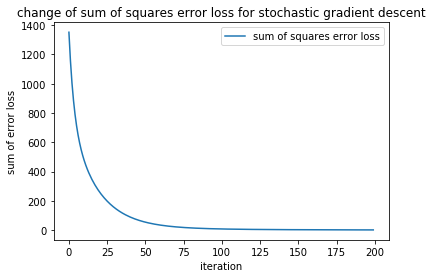

In [26]:
import warnings
warnings.filterwarnings('error')
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_accuracy = []
te_accuracy = []
threshold = 0

tr_ind_n = np.empty([1,0])
te_ind_n = np.empty([1,0])

for i in range(len(tr_ind)):
    if(labels[tr_ind[i]] == 1 or labels[tr_ind[i]] == 30):
        tr_ind_n = np.append(int(tr_ind[i]), tr_ind_n)

for i in range(len(te_ind)):
    if(labels[te_ind[i]] == 1 or labels[te_ind[i]] == 30):
        te_ind_n = np.append(int(te_ind[i]), te_ind_n)        

tr_ind_n = tr_ind_n.astype(int)
te_ind_n = te_ind_n.astype(int)

tr_data = data[tr_ind_n, :]
tr_label = labels[tr_ind_n]

try:
    cost_all, w_all = lls_sgd_train(tr_data, tr_label, 0.01, 200)
except:
    print("")

xsq = np.arange(0,200)
ysq = cost_all
plt.title("change of sum of squares error loss for stochastic gradient descent")
plt.plot(xsq, ysq, label = "sum of squares error loss")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("sum of error loss")

plt.show()

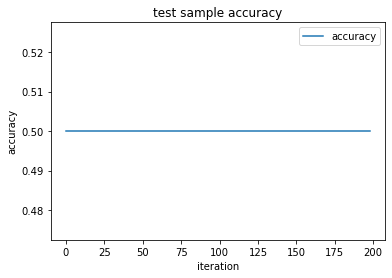

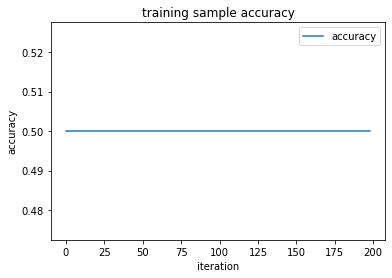

In [31]:
#Selects data
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_accuracy = []
te_accuracy = []
threshold = 0
tr_ind_n = np.empty([1,0])
te_ind_n = np.empty([1,0])

for i in range(len(tr_ind)):
    if(labels[tr_ind[i]] == 1 or labels[tr_ind[i]] == 30):
        tr_ind_n = np.append(int(tr_ind[i]), tr_ind_n)

for i in range(len(te_ind)):
    if(labels[te_ind[i]] == 1 or labels[te_ind[i]] == 30):
        te_ind_n = np.append(int(te_ind[i]), te_ind_n)        

tr_ind_n = tr_ind_n.astype(int)
te_ind_n = te_ind_n.astype(int)

#training data
tr_data = data[tr_ind_n, :]
#real labels
r_labels = labels[tr_ind_n]
#training labels
tr_labels = np.empty([1,0])

for i in range(len(tr_ind_n)):
    if(labels[tr_ind_n[i]] == 1):
        tr_labels = np.append(-1, tr_labels)
    else:
        tr_labels = np.append(1, tr_labels)
tr_labels = tr_labels.astype(int)
try:
    cost_all, w_all = lls_sgd_train(tr_data, tr_labels, 0.01, 200)
except:
    print("")

for k in range(199,0,-1):
    #weight
    weight = w_all[k].T
    #training prediction
    tr_prediction = l2_rls_predict(weight , tr_data)
    #testing data
    te_data = data[te_ind_n, :]
    #testing labels
    te_labels = labels[te_ind_n]
    #testing prediction
    te_prediction = l2_rls_predict(weight, te_data)

    #thresholding
    predicted_labels = np.empty([1,0])

    for i in range(len(te_prediction)):
        if (te_prediction[i] >= threshold):
            predicted_labels = np.append(int(30),predicted_labels)
        else:
            predicted_labels = np.append(int(1),predicted_labels)


    predicted_labels = predicted_labels.astype(int)
    tr_predicted_labels = np.empty([1,0])
    for i in range(len(tr_prediction)):
        if (tr_prediction[i] >= threshold):
            tr_predicted_labels = np.append(int(30),tr_predicted_labels)
        else:
            tr_predicted_labels = np.append(int(1),tr_predicted_labels)


    tr_predicted_labels = tr_predicted_labels.astype(int)


    te_accuracy.append(np.count_nonzero(predicted_labels == te_labels)/ len(te_labels))
    tr_accuracy.append(np.count_nonzero(tr_predicted_labels == r_labels)/ len(r_labels))



xsq = np.arange(0,199)
ysq = te_accuracy
plt.title("test sample accuracy")
plt.plot(xsq, ysq, label = "accuracy")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("accuracy")

plt.show()

xsq = np.arange(0,199)
ysq = tr_accuracy

plt.title("training sample accuracy")
plt.plot(xsq, ysq, label = "accuracy")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("accuracy")

plt.show()

#### Report  

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

#### Remember that all graphs should have axis labels and a title.